# Exponential Smoothing

In [16]:
# Packages
import pandas as pd
from matplotlib import pyplot as plt
import scipy.stats as stats
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_absolute_error

## Load data

In [17]:
# Read excel in ../Data/Clean_McBroken_Daily.xlsx
df = pd.read_excel('../Data/Clean_McBroken_Daily.xlsx')
df

,Date,Broken Machines,Total Machines,Percent Broken,Revenue Losses,Outlier,Train
0,2020-10-25,354.0,6818.0,5.192138,221250.0,False,True
1,2020-10-26,373.0,6844.0,5.450029,233125.0,False,True
2,2020-10-27,427.0,7488.0,5.702457,266875.0,False,True
3,2020-10-28,391.0,8294.0,4.714251,244375.0,False,True
4,2020-10-29,374.0,7461.0,5.012733,233750.0,False,True
...,...,...,...,...,...,...,...
1571,2025-02-12,1277.0,11636.0,10.974562,798125.0,False,False
1572,2025-02-13,1189.0,11707.0,10.156317,743125.0,False,False
1573,2025-02-14,1068.0,11428.0,9.345467,667500.0,False,False
1574,2025-02-15,1107.0,11773.0,9.402871,691875.0,False,False


## Exponential Smoothing

In [18]:
# Count missing and outlier cases
print('Missing cases:', df['Revenue Losses'].isnull().sum())
# Mark missing cases
df['Missing'] = df['Revenue Losses'].isnull()
print('Outlier cases:', df['Outlier'].sum())

Missing cases: 129
Outlier cases: 119


In [19]:
# Set missing and outlier cases to their 7-day lag
df['7-day lag'] = df['Revenue Losses'].shift(7)
df['Revenue Losses'] = [df['7-day lag'][i] if df['Revenue Losses'].isnull()[i] else df['Revenue Losses'][i] for i in range(len(df))]
df['Revenue Losses'] = [df['7-day lag'][i] if df['Outlier'][i] else df['Revenue Losses'][i] for i in range(len(df))]

In [20]:
# For ETS, limit data to last year
# This will both take care of outliers and minimize missing data
df = df[df['Date'] >= df['Date'].max() - pd.DateOffset(years=1)].reset_index(drop=True)
df

,Date,Broken Machines,Total Machines,Percent Broken,Revenue Losses,Outlier,Train,Missing,7-day lag
0,2024-02-16,241.0,3974.0,6.064419,1012500.0,True,True,False,1012500.0
1,2024-02-17,1511.0,15466.0,9.769818,944375.0,False,True,False,950625.0
2,2024-02-18,1816.0,15880.0,11.435768,1135000.0,False,True,False,1088125.0
3,2024-02-19,2004.0,15851.0,12.642735,1252500.0,False,True,False,1136875.0
4,2024-02-20,1908.0,15908.0,11.993965,1192500.0,False,True,False,1083125.0
...,...,...,...,...,...,...,...,...,...
362,2025-02-12,1277.0,11636.0,10.974562,798125.0,False,False,False,773125.0
363,2025-02-13,1189.0,11707.0,10.156317,743125.0,False,False,False,736875.0
364,2025-02-14,1068.0,11428.0,9.345467,667500.0,False,False,False,679375.0
365,2025-02-15,1107.0,11773.0,9.402871,691875.0,False,False,False,694375.0


In [21]:
# Count missing and outlier cases
print('Missing cases:', df['Missing'].sum())
print('Outlier cases:', df['Outlier'].sum())

Missing cases: 3
Outlier cases: 35


In [22]:
df = df[['Date', 'Revenue Losses', 'Train']]
df

,Date,Revenue Losses,Train
0,2024-02-16,1012500.0,True
1,2024-02-17,944375.0,True
2,2024-02-18,1135000.0,True
3,2024-02-19,1252500.0,True
4,2024-02-20,1192500.0,True
...,...,...,...
362,2025-02-12,798125.0,False
363,2025-02-13,743125.0,False
364,2025-02-14,667500.0,False
365,2025-02-15,691875.0,False


In [23]:
# Train/test split
train_df = df.query('Train == 1')
test_df = df.query('Train == 0')
print(len(train_df), len(test_df))

337 30


In [24]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Holt-Winters' Method
model_hw = ExponentialSmoothing(train_df['Revenue Losses'], 
                                trend="add", 
                                damped_trend=True,
                                seasonal="add", 
                                seasonal_periods=7, 
                                initialization_method="estimated")
fit_hw = model_hw.fit()
test_forecast = fit_hw.forecast(steps=30)

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [25]:
# Check residuals
def plot_exponential_smoothing_residuals(fit, lags=10, bins=20):
    """
    Generates and displays a suite of residual plots for Exponential Smoothing.

    Args:
        fit: The fitted ExponentialSmoothing model object.
        lags: Number of lags to plot in the ACF.
        bins: Number of bins for the histogram.
    """

    residuals = fit.resid
    fitted_values = fit.fittedvalues

    fig, axes = plt.subplots(3, 2, figsize=(15, 12))  # 3 rows, 2 columns of plots

    # 1. Time Series Plot of Residuals
    axes[0, 0].plot(residuals)
    axes[0, 0].set_title('Residuals over Time')
    axes[0, 0].set_xlabel('Date')  # Or time index
    axes[0, 0].set_ylabel('Residuals')
    axes[0, 0].grid(True)

    # 2. Histogram of Residuals
    axes[0, 1].hist(residuals, bins=bins)
    axes[0, 1].set_title('Histogram of Residuals')
    axes[0, 1].set_xlabel('Residuals')
    axes[0, 1].set_ylabel('Frequency')

    # 3. Q-Q Plot
    stats.probplot(residuals, dist="norm", plot=axes[1, 0])
    axes[1, 0].set_title('Q-Q Plot of Residuals')

    # 4. ACF Plot
    plot_acf(residuals, lags=lags, ax=axes[1, 1])  # Use the provided axes
    axes[1, 1].set_title('Autocorrelation Function (ACF)')

    # 5. Residuals vs. Fitted Values
    axes[2, 0].scatter(fitted_values, residuals)
    axes[2, 0].set_title('Residuals vs. Fitted Values')
    axes[2, 0].set_xlabel('Fitted Values')
    axes[2, 0].set_ylabel('Residuals')
    axes[2, 0].grid(True)

    # Remove the empty subplot if needed
    fig.delaxes(axes[2,1]) # if you don't want the 6th plot.

    plt.tight_layout()  # Adjust subplot params for a tight layout
    plt.show()

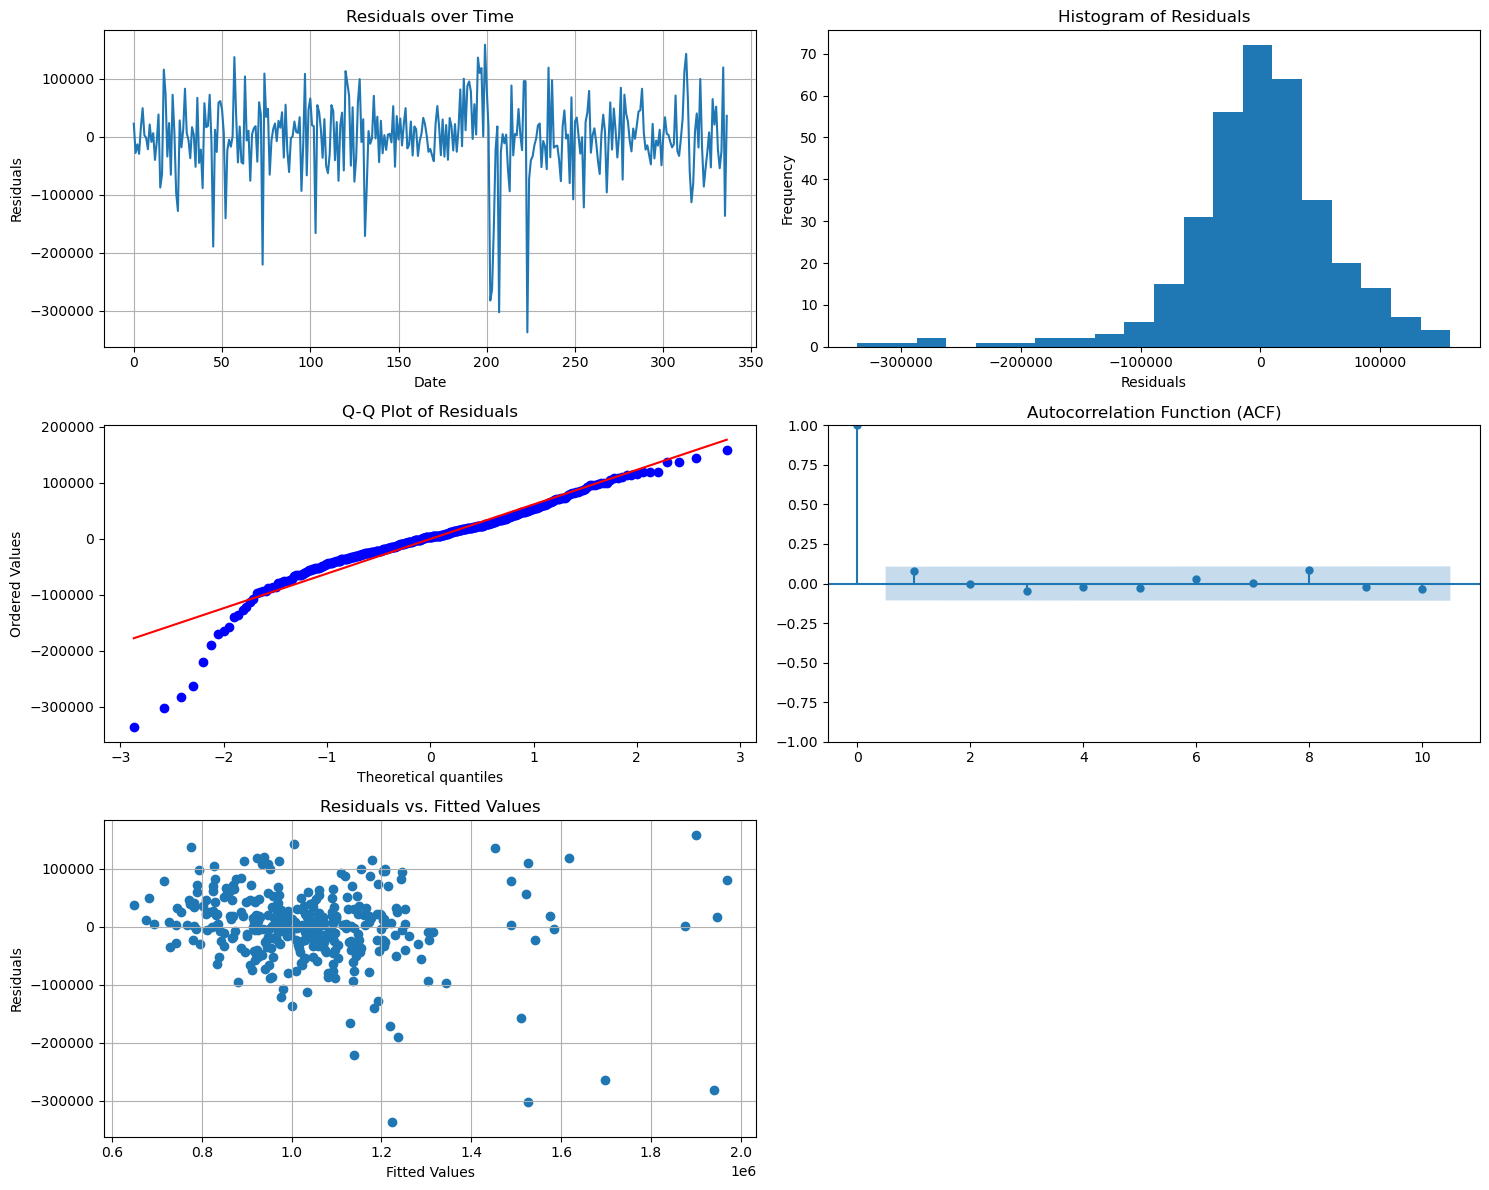

In [26]:
plot_exponential_smoothing_residuals(fit_hw)

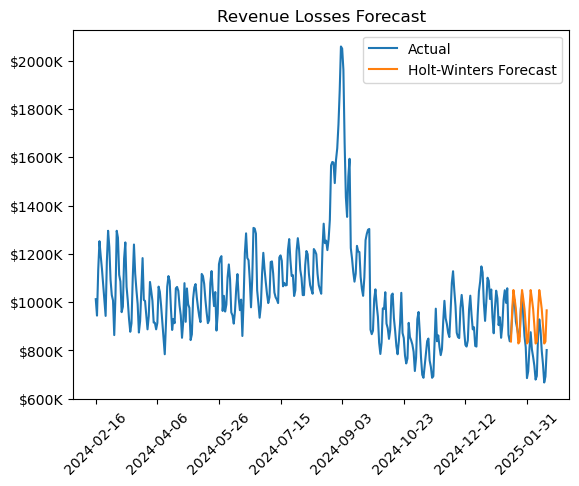

MAE: 104248.90875900308


In [27]:
plt.plot(df['Revenue Losses'], label="Actual")
plt.plot(test_forecast, label="Holt-Winters Forecast")
# Title of Revenue Losses Forecast
plt.title('Revenue Losses Forecast')
# Format y axis as thousands of dollars
plt.gca().yaxis.set_major_formatter((lambda x, _: f'${int(x/1000)}K'))
# Format x axis as dates - add x number of days to first date in data, format as date
plt.gca().xaxis.set_major_formatter((lambda x, _: (df['Date'][0] + pd.DateOffset(days=int(x))).strftime('%Y-%m-%d')))
# Rotate x axis labels
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Check MAE on test set
mae = mean_absolute_error(test_df['Revenue Losses'], test_forecast)
print('MAE:', mae)

c:\Users\ijyli\.local\share\mamba\envs\mcbroken-forecasting\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


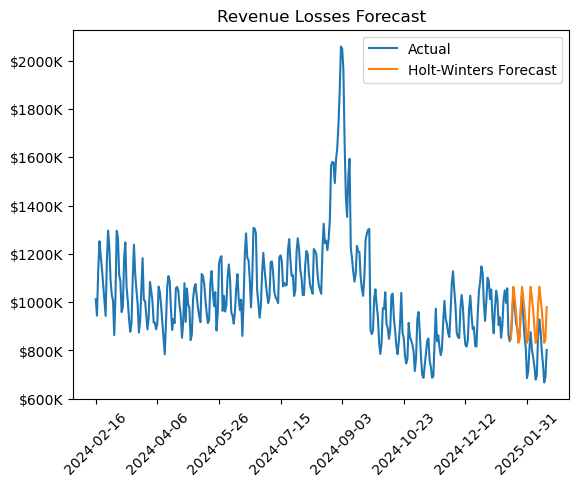

In [28]:
# Automatic
model_hw = ExponentialSmoothing(train_df['Revenue Losses'], 
                                # trend="add", 
                                # damped_trend=True,
                                seasonal="mul", 
                                seasonal_periods=7, 
                                initialization_method="estimated")
fit_hw = model_hw.fit()
test_forecast = fit_hw.forecast(steps=30)

plt.plot(df['Revenue Losses'], label="Actual")
plt.plot(test_forecast, label="Holt-Winters Forecast")
# Title of Revenue Losses Forecast
plt.title('Revenue Losses Forecast')
# Format y axis as thousands of dollars
plt.gca().yaxis.set_major_formatter((lambda x, _: f'${int(x/1000)}K'))
# Format x axis as dates - add x number of days to first date in data, format as date
plt.gca().xaxis.set_major_formatter((lambda x, _: (df['Date'][0] + pd.DateOffset(days=int(x))).strftime('%Y-%m-%d')))
# Rotate x axis labels
plt.xticks(rotation=45)
plt.legend()
plt.show()

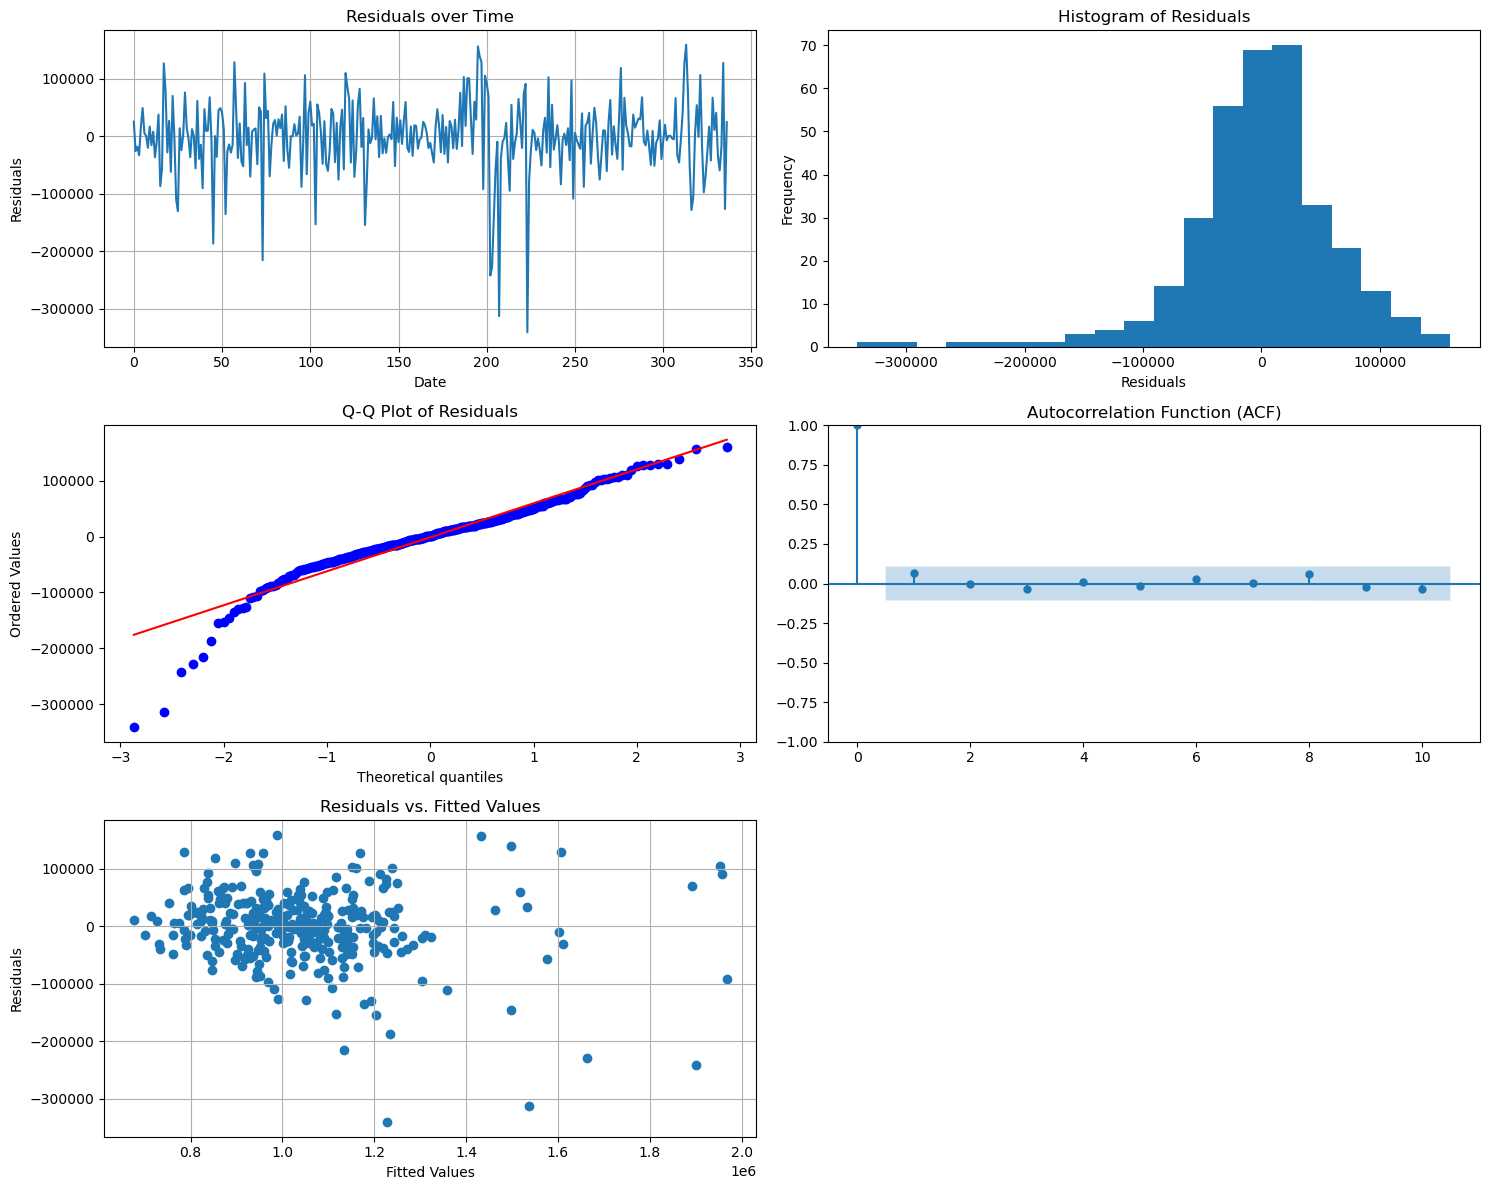

In [29]:
plot_exponential_smoothing_residuals(fit_hw)

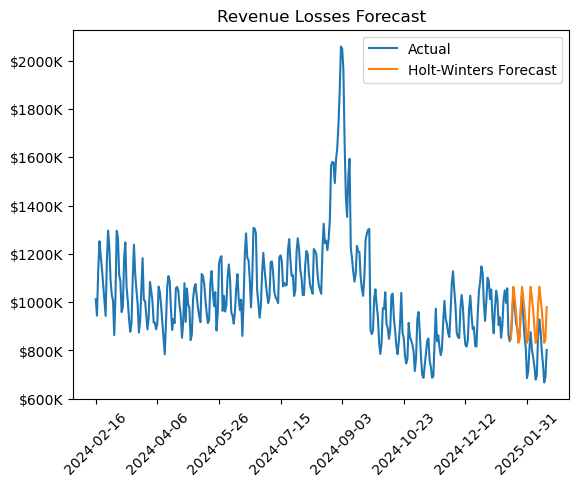

MAE: 108316.82158749866


In [30]:
plt.plot(df['Revenue Losses'], label="Actual")
plt.plot(test_forecast, label="Holt-Winters Forecast")
# Title of Revenue Losses Forecast
plt.title('Revenue Losses Forecast')
# Format y axis as thousands of dollars
plt.gca().yaxis.set_major_formatter((lambda x, _: f'${int(x/1000)}K'))
# Format x axis as dates - add x number of days to first date in data, format as date
plt.gca().xaxis.set_major_formatter((lambda x, _: (df['Date'][0] + pd.DateOffset(days=int(x))).strftime('%Y-%m-%d')))
# Rotate x axis labels
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Check MAE on test set
mae = mean_absolute_error(test_df['Revenue Losses'], test_forecast)
print('MAE:', mae)

Kind of limited in terms of what more can be done here ... more complex forecasting methods may be a better fit for this data (in particular, I think better accounting for cycles may be very useful).